In [8]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from skimage import io
from tqdm import tqdm
import os
%matplotlib inline

# Read Data

In [9]:
path = ''

In [10]:
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [11]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [12]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Read Images

In [14]:
image = io.imread(os.path.join(path, 'images_resize_gray', str(dataTraining.index[0]) + '_resize_gray.jpeg'))

In [15]:
image

array([[ 3,  3,  3, ..., 57, 55, 51],
       [ 3,  3,  3, ..., 99, 98, 95],
       [ 3,  3,  3, ..., 97, 96, 94],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

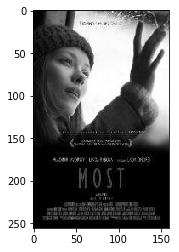

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(image, cmap='gray')

Read all images

In [17]:
images_training = []
for i in tqdm(dataTraining.index):
    images_training.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

100%|██████████| 7895/7895 [00:04<00:00, 1675.38it/s]


In [18]:
images_training = np.stack(images_training)

images_training.shape, dataTraining.shape[0]

((7895, 40960), 7895)

In [19]:
images_testing = []
for i in tqdm(dataTesting.index):
    images_testing.append(io.imread(os.path.join(path, 'images_resize_gray', str(i) + '_resize_gray.jpeg')).flatten())

images_testing = np.stack(images_testing)

images_testing.shape, dataTesting.shape[0]

100%|██████████| 3383/3383 [00:02<00:00, 1603.79it/s]


((3383, 40960), 3383)

## Apply PCA

In [20]:
pca = PCA(n_components=32)
images_training_pca = pca.fit_transform(images_training)

In [21]:
images_testing_pca = pca.transform(images_testing)

# Create y

In [22]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [23]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(images_training_pca, y_genres, test_size=0.33, random_state=42)

# Train multi-class multi-label model

In [24]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [25]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=1)

In [26]:
y_pred_genres = clf.predict_proba(X_test)

In [27]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.5832413775124384

# Apply models to test

In [24]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(images_testing_pca)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_img_RF.csv', index_label='ID')